# Analyzing correlations betweeen variables in customers

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


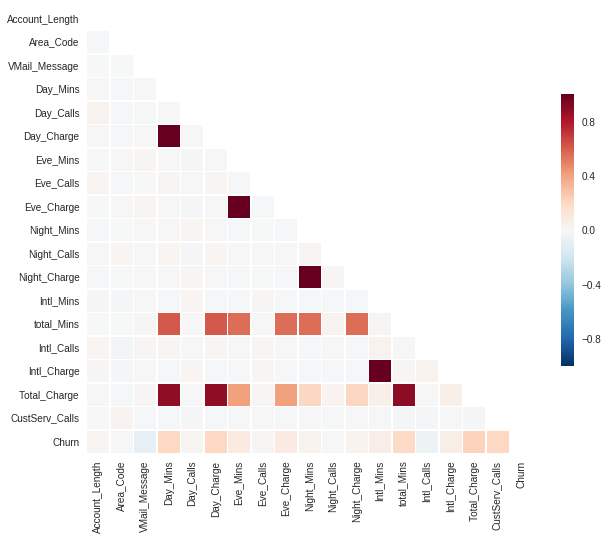

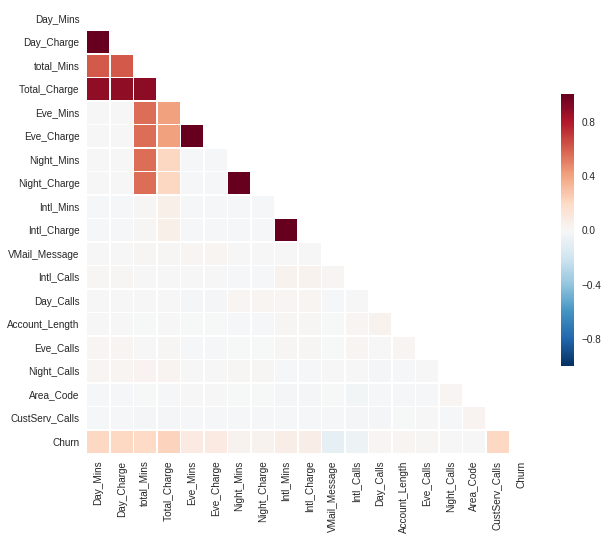

In [35]:
%pylab inline
import dataiku                          # Access to Dataiku datasets
import pandas as pd, numpy as np        # Data manipulation 
import scipy.cluster.hierarchy as sch   # Used for reordering the correlation matrix
import seaborn as sns                   # Graphing
sns.set(style="white")                  # Tuning the style of charts
import warnings                         # Disable some warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Take a handle on the dataset
mydataset = dataiku.Dataset("customers_prepared")

# Load the first 100'000 lines.
# You can also load random samples, limit yourself to some columns, or only load
# data matching some filters.
#
# Please refer to the Dataiku Python API documentation for more information
df = mydataset.get_dataframe(
    limit = 100000)

# Get the column names
numerical_columns = list(df.select_dtypes(include=[np.number]).columns)
categorical_columns = list(df.select_dtypes(include=[object]).columns)
date_columns = list(df.select_dtypes(include=['<M8[ns]']).columns)


# Select variables to plot for the correlation matrix
corr_matrix_vars = numerical_columns[0:50]


# Only select the requested columns
df_corr_matrix = df[corr_matrix_vars]

# This computes the Pearson coefficient for all couples
corr = df_corr_matrix.corr().fillna(0)

# Start drawing

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
size = max(10, len(corr.columns)/2.)
f, ax = plt.subplots(figsize=(size, size))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, square=True, linewidths=.5, cbar_kws={"shrink": 0.5}, ax=ax)

# Generate features and distance matrix.
D = corr.values
# Compute and plot dendrogram.
Y = sch.linkage(D, method='centroid')
Z = sch.dendrogram(Y, orientation='right',no_plot=True)
# Compute distance matrix.
index = Z['leaves']
D = D[index,:]
D = D[:,index]

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
size = max(10, len(corr.columns)/2.)
f, ax = plt.subplots(figsize=(size, size))

# Draw the heatmap with the mask and correct aspect ratio

sns.heatmap(D, mask=mask, square=True, linewidths=.5, cbar_kws={"shrink": 0.5}, ax=ax)
#ax.set(xticks=range(len(corr.columns)), xticklabels=corr.columns[index], yticks=range(len(corr.columns)), yticklabels=reversed(corr.columns[index]))
ax.set_xticklabels(corr.columns[index], rotation=90, ha='center');
ax.set_yticklabels(reversed(corr.columns[index]), rotation=0);

In [41]:
sns.pairplot

u'Intl_Plan'

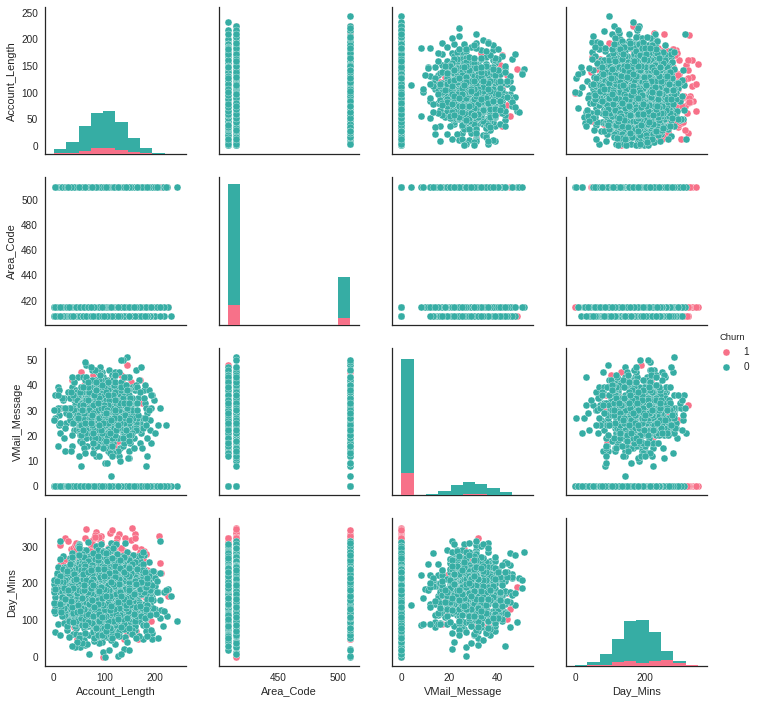

In [52]:
# Only generate the scatterplot matrix on a sample
df_scatter_samp = df.sample(min(5000, df.shape[0])) # 5000 points maximum on the scatter plot

# Take the first 4 numerical variables to plot the scatterplot matrix
scatter_matrix_vars = numerical_columns[0:4]

# If we have categorical variables, use the categorical variables with the lowest number of modalities
# to plot the points of the scatterplot
scatter_matrix_color = None

cat_cols_with_cards = [(x, df[x].nunique()) for x in categorical_columns]
# We don't want to take a column with only a single modality
# and also we don't want variables with more than 10 modalities (would not really make sense to plot)
cat_cols_with_cards_f = [x for x in cat_cols_with_cards if x[1] >= 2 and x[1] <= 10]

if len(cat_cols_with_cards_f) > 0:
    # We have at least one categorical variable with a good number of modalities, use it
    scatter_matrix_color = sorted(cat_cols_with_cards_f, key= lambda c : c[1])[0][0]

scatter_matrix_color = 'Churn'

# Seaborn (the graphic library) doesn't like NaNs, so fill the matrix
df_filled = df.fillna(0)
sns.pairplot(df_filled, vars = scatter_matrix_vars, hue_order=[1,0], hue=scatter_matrix_color, palette="husl")

## See the relation between two features, including categorical features <a id="two-vars" />

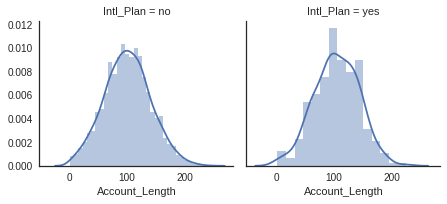

In [37]:
# Compute cardinalities of our categorical variables
cat_cols_with_cards = [(x, df[x].nunique()) for x in categorical_columns]

# For proper display, we only want columns with modalities between 2 and 10
cat_cols_with_cards_f = [x for x in cat_cols_with_cards if x[1] >= 2 and x[1] <= 10]

nb_suitable_cats = len(cat_cols_with_cards_f)
nb_num = len(numerical_columns)

if nb_suitable_cats >= 1 and nb_num >= 1:
    tf_feat1 = cat_cols_with_cards_f[0][0]
    tf_feat2 = numerical_columns[0]

elif nb_suitable_cats == 0 and nb_num >= 2:
    tf_feat1 = numerical_columns[0]
    tf_feat2 = numerical_columns[1]

else:
    raise ValueError("Failed to automatically select proper variables to plot, please select manually")




if tf_feat1 in numerical_columns and tf_feat2 in numerical_columns:
    sns.pairplot(df[[tf_feat1, tf_feat2]])
    
if tf_feat1 in numerical_columns and tf_feat2 in categorical_columns:
    sns.FacetGrid(df, col=tf_feat2, col_wrap=5, hue=None).map(sns.distplot, tf_feat1)
    
if tf_feat1 in categorical_columns and tf_feat2 in numerical_columns:
    sns.FacetGrid(df, col=tf_feat1, col_wrap=5, hue=None).map(sns.distplot, tf_feat2)
    
if tf_feat1 in categorical_columns and tf_feat2 in categorical_columns:
    tf_list = [tf_feat1, tf_feat2]
    tf_unique_count = [df[feat].unique().__len__() for feat in tf_list]
    tf_min_loc = tf_unique_count.index(min(tf_unique_count))
    sns.FacetGrid(data=df, col=tf_list[tf_min_loc], col_wrap=5, hue=None).map(sns.countplot, tf_list[(tf_min_loc+1)%2], order=df[tf_list[(tf_min_loc+1)%2]].unique())